In [1]:
from drug_objects import drug, review, drug_dataset

In [2]:
import sys, pickle, re
from time import time
from collections import Counter, OrderedDict

import pandas as pd 
# from itertools import islice
import itertools

import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

from matplotlib import gridspec
import matplotlib.cm as cm

%matplotlib inline

In [3]:
from numpy.random import uniform, seed
from matplotlib.mlab import griddata
from numpy import linspace, meshgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.random import uniform, seed

In [13]:
from sklearn import cluster, datasets, metrics
from sklearn.metrics import euclidean_distances, confusion_matrix

from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split

from textblob import TextBlob

In [5]:
from data_fxns import build_drug_dataset, binning_fxn, filter_count_scores, double_confusionPlot, plot_confusion_matrix

#### Load one drug dataset

In [ ]:
one_drug, dataset = build_drug_dataset('single', 'drug_list_ddc_mini.p')

#### Merge generics

In [6]:
one_drug, dataset = build_drug_dataset('generic', 'drug_list_ddc_pg1.p', 5)

duloxetine systemic 950 897
sertraline systemic 1225 1151
escitalopram systemic 1050 985
fluoxetine systemic 750 702
citalopram systemic 825 775
bupropion systemic 1300 1207
aripiprazole systemic 250 237
venlafaxine systemic 1000 947
desvenlafaxine systemic 600 557
mirtazapine systemic 325 302
vilazodone systemic 525 485


#### All drug dataset

In [ ]:
one_drug, dataset = build_drug_dataset('all', 'drug_list_ddc_pg1.p')

##### Info:

In [19]:
print(one_drug.attributes)
print(one_drug.__dict__.keys())

['drugName', 'site', 'condition', 'reviewDate', 'userName', 'ageRange_str', 'gender', 'role', 'medDuration_str', 'effectiveness', 'ease_of_use', 'satisfaction', 'genRating', 'upVotes']


### Split off subsets

In [17]:
one_drug.attributeDetails['medDuration_str']

{'[6, 12]', '[120, 300]', '[60, 120]', '[1, 6]', '[0, 1]', '[24, 60]', None}

In [138]:
attr = 'medDuration_str'

medDur_d = {}
for subset in one_drug.attributeDetails[attr]:
    medDur_d[str(subset)] = one_drug.slice_data(attr, subset)
    print(str(subset), len(medDur_d[str(subset)]))
    
frames = [medDur_d['[0, 1]'], medDur_d['[1, 6]'], medDur_d['[6, 12]']]

leq_1year = pd.concat(frames)
leq_1year.describe()
# make dataset from a particular slice
dataset = drug_dataset(leq_1year)

[24, 60] 1152
[60, 120] 643
[120, 300] 461
[1, 6] 4190
[0, 1] 3571
None 0
[6, 12] 1433


In [17]:
len(one_drug.df), len(dataset.data)

(450, 426)

### Rebinning (10 bins to 5)

##### Not re-binned labels

In [12]:
labels = dataset.target
target_names = dataset.target_names

##### 5 bins (model 1): 

In [7]:
bin_conversion = OrderedDict({1:'1-2', 2:'1-2', 3:'3-4', 4:'3-4',5:'5-6', 6:'5-6', 7:'7-8', 8:'7-8', 9:'9-10', 10:'9-10'})
labels, target_names = binning_fxn(bin_conversion, dataset)

## Extracting features from the training dataset using a sparse vectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

count_vect = CountVectorizer(min_df = 2, lowercase=True, ngram_range=(1,2), stop_words='english')
transformer = TfidfTransformer()

X = count_vect.fit_transform(dataset.data)
X_tfidf = transformer.fit_transform(X)

In [9]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.2, random_state=0)

## Classifiers: Train-Test

In [15]:
from sklearn.model_selection import cross_val_score, KFold

In [11]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

mlp classifier
SGDC with log loss
log reg
multinomial NB
DecisionTree


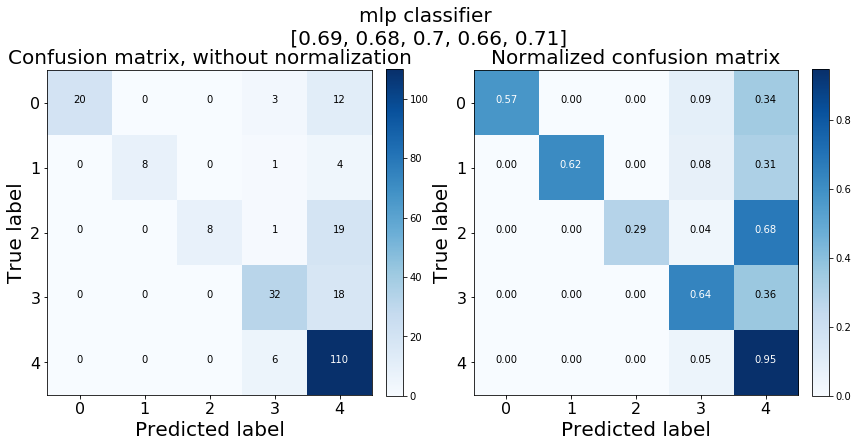

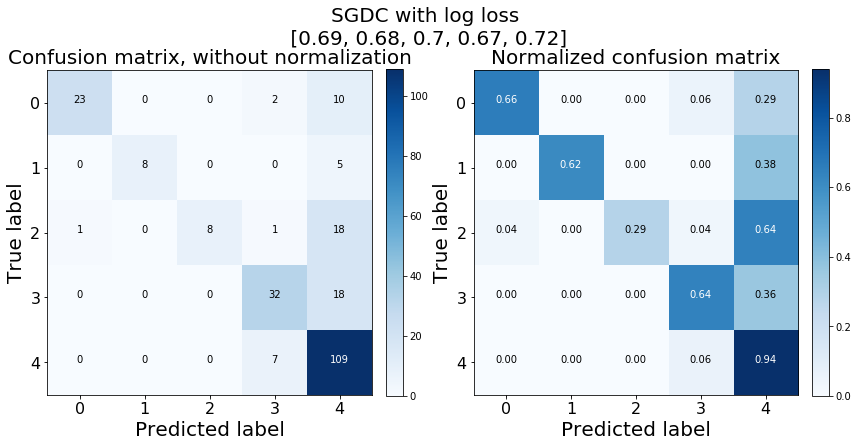

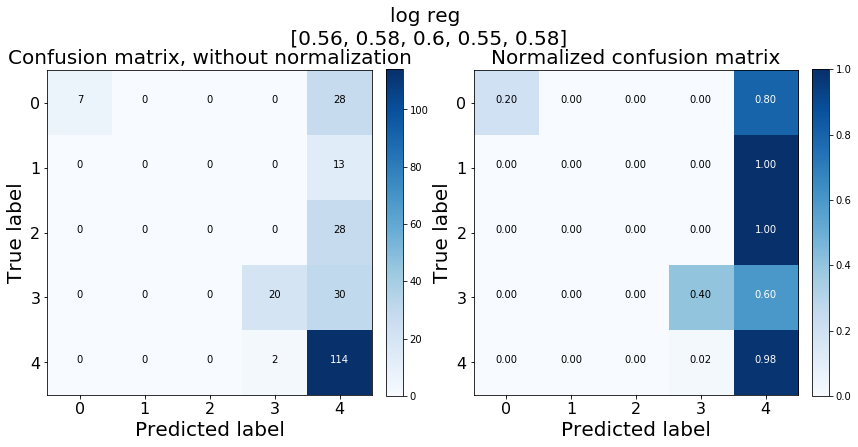

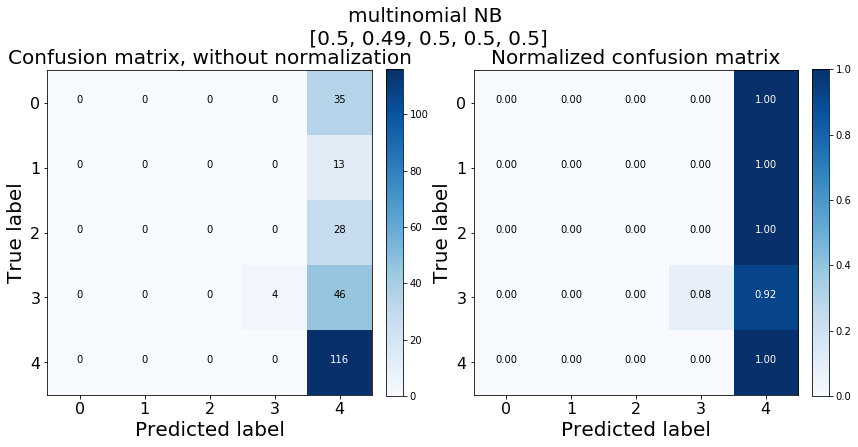

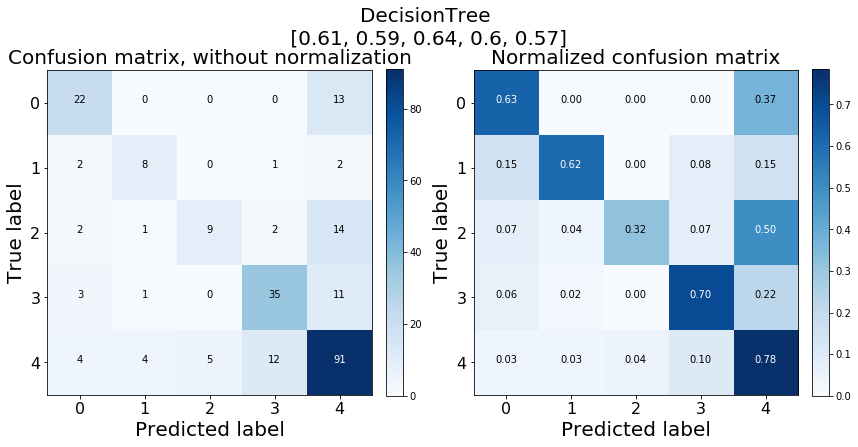

In [18]:
classifiers = {'mlp classifier': MLPClassifier(alpha=1), 'SGDC with log loss': SGDClassifier(loss= 'log', tol = 1e-3),"log reg": LogisticRegression(solver= 'lbfgs', multi_class='multinomial'), 'multinomial NB': MultinomialNB(),'DecisionTree': DecisionTreeClassifier()}

for key in classifiers:
    classifier = classifiers[key]
    cvs = cross_val_score(classifier,X_train_tfidf, y_train, cv = 5, scoring='accuracy')
    y_pred = classifier.fit(X_train_tfidf, y_train).predict(X_test_tfidf)

    # Plot confusion matrices
    key_cvs_str = key+'\n ['+", ".join(str(round(x,2)) for x in cvs) + ']'
    double_confusionPlot(y_test, y_pred, key_cvs_str, 'Predicted label', 'True label', target_names)


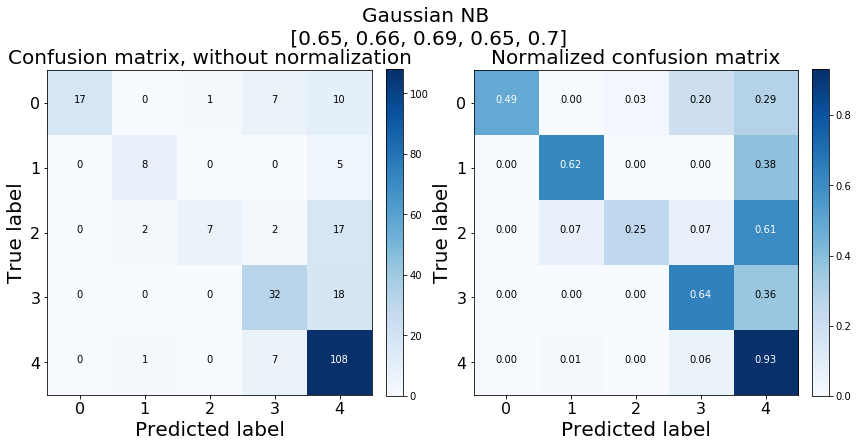

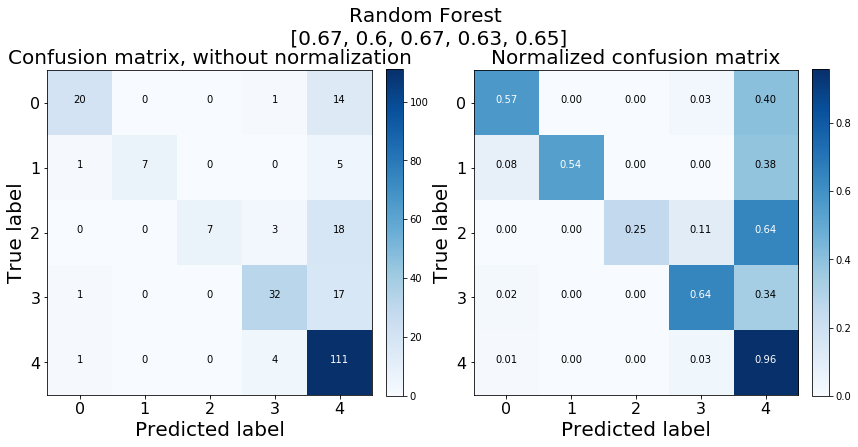

In [17]:
# Now let's try to do the random forest 
from sklearn.ensemble import RandomForestClassifier

X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

classifiers = {'Gaussian NB': GaussianNB(), "Random Forest": RandomForestClassifier(n_estimators = 10) }

for key in classifiers:
    classifier = classifiers[key]
    cvs = cross_val_score(classifier,X_train_tfidf_dense, y_train, cv=5, scoring='accuracy')
    y_pred = classifier.fit(X_train_tfidf_dense, y_train).predict(X_test_tfidf_dense)

    key_cvs_str = key+'\n ['+", ".join(str(round(x,2)) for x in cvs) + ']'
    double_confusionPlot(y_test, y_pred, key_cvs_str, 'Predicted label', 'True label', target_names)


## TextBlob Analysis

Counter({3: 889, 2: 280, 4: 30, 1: 5, 5: 3})


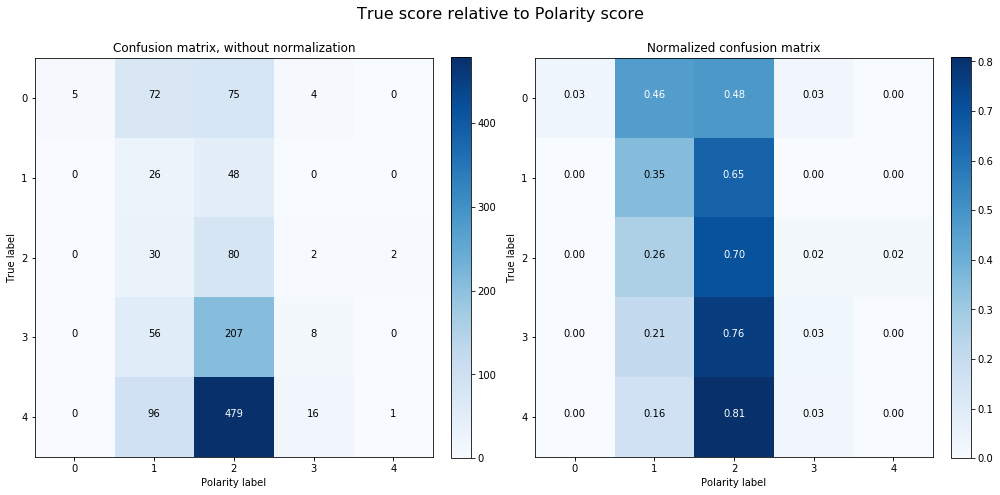

In [78]:
# same code as in cluster analysis in order to probe textblob-ypred comparisons for both types of models
blob_scores = []
blob_data = X_test
for ik in range(len(blob_data)):
    blob = TextBlob(blob_data[ik])
    blob_scores.append(blob.polarity)
    
blob_scores = np.array(blob_scores)
hist, bin_edges = np.histogram(blob_scores, bins=5) #int(len(blob_scores)/10))
bins = np.linspace(-1, 1, 5)
bin_inds = np.digitize(blob_scores, bins)

c = Counter(bin_inds)

double_confusionPlot(y_pred, bin_inds, 'Predicted score relative to Polarity score', 'Polarity label', 'Model Prediction', target_names)